# 1. Quá trình dự báo trên mô hình LR

## Thêm thư viện

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
# from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

In [3]:
# Load data
df = pd.read_csv('../../data/btc.csv')
print(df)
name_col='close'

     formatted_date          high           low          open         close  \
0        2014-09-17    468.174011    452.421997    465.864014    457.334015   
1        2014-09-18    456.859985    413.104004    456.859985    424.440002   
2        2014-09-19    427.834991    384.532013    424.102997    394.795990   
3        2014-09-20    423.295990    389.882996    394.673004    408.903992   
4        2014-09-21    412.425995    393.181000    408.084991    398.821014   
...             ...           ...           ...           ...           ...   
3017     2022-12-21  16916.800781  16755.912109  16904.527344  16817.535156   
3018     2022-12-22  16866.673828  16592.408203  16818.380859  16830.341797   
3019     2022-12-23  16905.218750  16794.458984  16829.644531  16796.953125   
3020     2022-12-24  16864.703125  16793.527344  16796.976562  16847.755859   
3021     2022-12-25  16859.472656  16824.105469  16847.066406  16830.982422   

           volume      adjclose  
0        21056800

In [4]:
# Process data
df['H-L'] = df['high'] - df['low']
df['O-C'] = df['open'] - df['close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df[name_col].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df[name_col].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df[name_col].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df[name_col].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df[name_col].rolling(window=ma_3).std()
df.dropna(inplace=True)

df.to_csv(f"../../predict/bitcoin_df_{name_col}.csv")
df.set_index('formatted_date')

,high,low,open,close,volume,adjclose,H-L,O-C,SMA_7,SMA_14,SMA_21,SD_7,SD_21
formatted_date,,,,,,,,,,,,,
2014-10-07,339.247009,320.481995,330.584015,336.187012,49199900,336.187012,18.765015,-5.602997,347.691572,372.296927,387.352142,24.885399,36.587375
2014-10-08,354.364014,327.187988,336.115997,352.940002,54736300,352.940002,27.176025,-16.824005,343.309431,367.278000,382.380999,19.656765,33.571190
2014-10-09,382.726013,347.687012,352.747986,365.026001,83641104,365.026001,35.039001,-12.278015,341.874289,363.953142,379.551761,17.159362,32.330045
2014-10-10,375.066986,352.963013,364.687012,361.562012,43665700,361.562012,22.103973,3.125000,342.167149,360.891501,377.969190,17.524172,32.359917
2014-10-11,367.191010,355.950989,361.362000,362.299011,13345200,362.299011,11.240021,-0.937012,346.943294,358.232860,375.749906,17.847829,31.724161
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-21,16916.800781,16755.912109,16904.527344,16817.535156,14882945045,16817.535156,160.888672,86.992188,16818.419643,17080.849191,17054.231492,283.780350,326.829495
2022-12-22,16866.673828,16592.408203,16818.380859,16830.341797,16441573050,16830.341797,274.265625,-11.960938,16742.059152,17052.053990,17047.717634,154.871238,329.999982
2022-12-23,16905.218750,16794.458984,16829.644531,16796.953125,15329265213,16796.953125,110.759766,32.691406,16763.411830,17028.039760,17033.826823,149.882179,334.301829


## Nạp dữ liệu từ file csv

In [5]:
df2 = pd.read_csv(f"../../predict/bitcoin_df_{name_col}.csv", parse_dates=True)
for i in range(0,len(df2)-1) :
    df2[name_col][i]=df2[name_col][i+1]

split_x = df2[['high','low','open','H-L', 'O-C', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}','formatted_date']]
split_y = df2[[name_col]]

X_train, X_test,y_train, y_test = train_test_split(split_x,split_y ,
                                   random_state=104, 
                                   test_size=0.2, 
                                   shuffle=True)
print(X_train)

              high           low          open          H-L          O-C  \
2350  61597.917969  59302.316406  61221.132812  2295.601562  1918.816406   
2139  11963.203125  11768.697266  11768.697266   194.505859   -97.000977   
1453   6643.100098   6511.649902   6643.100098   131.450195    41.140137   
1603   3891.578857   3837.986328   3878.697266    53.592529    24.339355   
1677   7333.002930   6375.698730   6379.666992   957.304199  -825.104492   
...            ...           ...           ...          ...          ...   
654     666.583008    646.721985    664.921997    19.861023    14.302979   
1275   7469.879883   6803.879883   7456.410156   666.000000   602.570312   
729     613.814026    609.617004    610.218018     4.197021    -2.292969   
1729  10912.188477   9737.884766  10588.683594  1174.303711  -212.994141   
69      351.815002    344.933990    351.360992     6.881012     6.015991   

             SMA_7        SMA_14        SMA_21         SD_7        SD_21  \
2350  56965

## Chuẩn hóa dữ liệu

In [6]:
cols_x = ['high','low','open','H-L', 'O-C', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = [name_col]
x_train = X_train[cols_x].values.reshape(-1, len(cols_x))
y_train = y_train[cols_y].values.reshape(-1, len(cols_y))
print(x_train.shape, y_train.shape)

(2401, 10) (2401, 1)


In [7]:

x_test = X_test[cols_x].values.reshape(-1, len(cols_x))
y_test = y_test[cols_y].values.reshape(-1, len(cols_y))
print(x_test.shape, y_test.shape)

(601, 10) (601, 1)


# 2. Quá trình dự đoán trên mô hình 


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor

In [9]:
_gdm = ('gradientboosting', GradientBoostingRegressor(learning_rate= 0.07, max_depth= 8, n_estimators= 1000, subsample= 0.3));
_elm = ('elasticnet', ElasticNet(alpha= 0.01, l1_ratio= 0.8, positive= True, random_state= 100, selection= 'random', tol= 0.2, warm_start= True));
_lsm = ('lasso', Lasso(alpha= 3.17, copy_X= True, fit_intercept= False, max_iter= 1, normalize= True, positive= False, precompute= False, random_state= None, selection= 'random', tol= 0.3, warm_start= False));
_ridge = ('ridge',Ridge(alpha= 0.0006, copy_X= True, fit_intercept= False, max_iter= 1, normalize= False, positive= True, random_state= None, solver= 'auto', tol= 0.001));
_lr = ('linear',LinearRegression())

In [10]:
from itertools import permutations 
perm = permutations([_lr, _gdm, _lsm, _ridge]) 
_estimator_elm = []
for i in list(perm): 
    _estimator_elm.append(i)

In [11]:
parameters = {'estimators':_estimator_elm,  
              'final_estimator':_elm}
elm_grid = GridSearchCV(StackingRegressor(estimators= None, final_estimator = None),parameters, scoring='r2', cv=None).fit(x_train, y_train.reshape(-1, 1))
print(elm_grid.best_params_)
elm_reg = StackingRegressor(estimators= elm_grid.best_params_["estimators"], final_estimator = elm_grid.best_params_["final_estimator"])
elm_reg.fit(x_train, y_train.reshape(-1, 1))
elm_pred = elm_reg.predict(x_test)

,high,low,open,H-L,O-C,SMA_7,SMA_14,SMA_21,SD_7,SD_21,formatted_date,predict
60,4053.906738,4021.542480,4028.514648,32.364258,4.546387,4045.489118,3988.551322,3948.847621,24.957663,82.557692,2019-03-22,4086.099218
906,32218.406250,31100.673828,31841.550781,1117.732422,420.011719,32806.171038,33436.531110,33702.831938,972.009327,1140.263159,2021-07-16,31267.185968
1009,61435.183594,58208.187500,60352.000000,3226.996094,1869.613281,61016.127790,61482.505022,59485.507068,1450.352411,3475.341140,2021-10-27,58237.195319
746,38225.906250,36658.761719,36931.546875,1567.144531,-1212.761719,35567.687500,34034.436244,34310.981678,1997.550126,2193.336858,2021-02-05,38154.760505
1335,20127.234375,19387.492188,20127.234375,739.742188,707.728516,20275.589007,20287.876256,20194.787946,977.052186,889.991492,2022-09-18,19424.023199


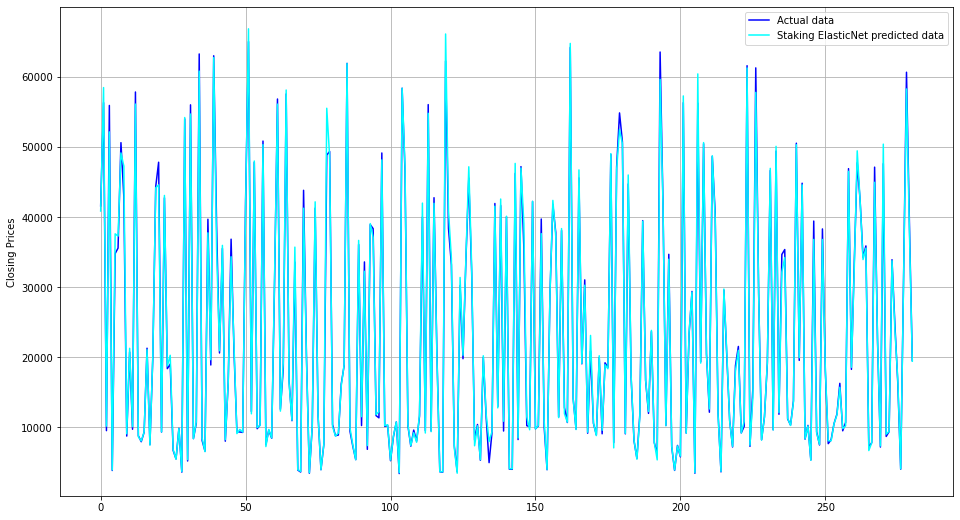

In [ ]:

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(y_test, 'blue', label='Actual data')
plt.plot(elm_pred, 'cyan', label='Staking ElasticNet predicted data')
plt.legend()
X_test['predict']=elm_pred
X_test.tail()

In [ ]:
import pickle

In [ ]:
filename = f'../../model/stacking/stacking_{name_col}.h5'
pickle.dump(elm_reg, open(filename, 'wb'))